# Lab 6: 
## Final - Assignment - PyTorch - 2 verions with Images Input & Visualization - Version #1

### Full Name: Nguyen Anh Thư
### Student's ID: 23127266

## Environment Setup

Import required libraries: `torch`, `numpy`

In [38]:
# Uncomment if required to install dependencies for this lab


#!pip -q install torch numpy

In [39]:
# %pip install torchviz graphviz


In [40]:
# import torch
# import numpy as np
# import torch.nn as nn

# print(f"PyTorch version: {torch.__version__}")
# print(f"NumPy version: {np.__version__}")


### Download dataset from kaggle

In [41]:
# %pip install kagglehub

In [42]:

# import kagglehub

# # Download latest version
# path = kagglehub.dataset_download("scolianni/mnistasjpg")

# print("Path to dataset files:", path)

In [43]:
# import shutil
# import os

# target_path = os.path.join(os.getcwd(), "mnistasjpg_data")

# if not os.path.exists(target_path):
#     shutil.move(path, target_path)
#     print(f"Dataset moving to: {target_path}")
# else:
#     print(f"Folder {target_path} was exist.")

# print("Files in folders:", os.listdir(target_path))

In [44]:
DATASET_DIR = "mnistasjpg_data"

TRAINING_SET = "mnist_trainingSet.csv"
TRAINING_SAMPLE = "mnist_trainingSample.csv"

MODEL_TRAINING_SAMPLE = "ffnn_mnist_state_dict.pt"
MODEL_TRAINING_SET = "ffnn_mnist_state_dict_set.pt"

## Pre-processing dataset

In [45]:
import os
import torch
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt

In [46]:
# ==========================================
# 1. SETUP & CONFIGURATION (Relative Paths)
# ==========================================
BASE_DIR = os.getcwd()
# Ensure this matches your folder structure exactly
DATA_DIR = os.path.join(BASE_DIR, DATASET_DIR)

# Hyperparameters based on PDF experiments 
CONFIG = {
    'mode': 'sample',      # Toggle between 'sample' and 'set'
    'input_size': 784,     # 28x28 pixels flattened
    'hidden_size': 128,     # Hidden neurons
    'output_size': 10,     # 10 digits (0-9)
    'epochs': 100,         # Reduced for sample testing 
    'learning_rate': 0.2   # Standard LR from Lab
}

In [47]:
def visualize_input_images_from_csv(csv_path: str, num_images: int = 10):
    """
    Visualize raw input images from MNIST-like CSV.
    """
    df = pd.read_csv(csv_path)
    picked = np.random.choice(len(df), size=min(num_images, len(df)), replace=False)

    plt.figure(figsize=(12, 4))
    for i, idx in enumerate(picked):
        x = df.drop(columns=["label"]).iloc[idx].to_numpy(dtype=np.float32)
        if np.max(x) > 1.5:
            x = x / 255.0

        plt.subplot(2, 5, i + 1)
        plt.imshow(x.reshape(28, 28), cmap="gray")
        plt.title(f"Label: {int(df.loc[idx, 'label'])}")
        plt.axis("off")

    plt.tight_layout()
    plt.show()

In [48]:
def visualize_model_graph(model, input_size=784):
    """
    Visualize computation graph using torchviz.
    """
    try:
        from torchviz import make_dot
    except ImportError:
        raise ImportError("Install torchviz: pip install torchviz")

    x = torch.randn(1, input_size)
    y = model.forward(x)
    dot = make_dot(y, params=dict(model.named_parameters()))
    return dot


In [49]:
def load_and_normalize_data(manifest_df, output_size=10):
    """
    Loads images, flattens them, and scales features to [0, 1] using column max.
    
    Args:
        manifest_df (pd.DataFrame): Manifest with paths and labels.
        output_size (int): Number of classes for one-hot encoding.
        
    Returns:
        tuple: (X_normalized, y_onehot, max_values)
            - X_normalized: Normalized feature matrix (N, 784).
            - y_onehot: Label matrix (N, 10).
            - max_values: The per-column maximum values used for scaling[cite: 453].
    """
    x_raw = []
    y_raw = []
    
    for _, row in manifest_df.iterrows():
        # Load grayscale image and flatten [cite: 452]
        img = cv2.imread(row['path'], cv2.IMREAD_GRAYSCALE)
        x_raw.append(img.flatten().astype(np.float32))
        
        # One-hot encoding of labels [cite: 176-179, 445-447]
        label_vec = np.zeros(output_size)
        label_vec[int(row['label'])] = 1.0
        y_raw.append(label_vec)
        
    X = torch.tensor(np.array(x_raw), dtype=torch.float)
    y = torch.tensor(np.array(y_raw), dtype=torch.float)

    # Column-wise normalization: X_norm = X / max(X_column) 
    max_values, _ = torch.max(X, dim=0)
    max_values[max_values == 0] = 1.0  # Prevent division by zero
    X_normalized = torch.div(X, max_values)
    
    return X_normalized, y, max_values

In [50]:
def build_mnist_like_csv(dataset_root: str, split: str, out_csv: str, normalize: str = "div255"):
    """
    Convert an image-folder dataset into a MNIST-like CSV (label + 784 pixels).

    Input:
        dataset_root (str): Relative/absolute path to dataset root (e.g., "mnistasjpg_data").
        split (str): Split folder name (e.g., "trainingSample", "testSample", "trainingSet", "testSet").
        out_csv (str): Relative/absolute output CSV path (e.g., "mnist_trainingSample.csv").
        normalize (str): "div255" (0..1) or "none" (0..255).

    Output:
        tuple[str, dict]: (saved_csv_path, stats)
            stats keys: rows, cols(=785), chosen_dir, skipped
    """
    from pathlib import Path
    import numpy as np
    import pandas as pd

    try:
        from PIL import Image
    except Exception as e:
        raise ImportError("PIL is required. Install with: pip install pillow") from e

    def _pick_split_dir(root: Path, split_name: str) -> Path:
        outer = root / split_name
        inner = root / split_name / split_name
        if inner.is_dir():
            return inner
        if outer.is_dir():
            return outer
        raise FileNotFoundError(f"Split folder not found: {outer} (or nested {inner})")

    def _load_as_28x28_flat(path: Path) -> np.ndarray | None:
        img = Image.open(path).convert("L")
        if img.size != (28, 28):
            img = img.resize((28, 28), resample=Image.BILINEAR)
        arr = np.asarray(img, dtype=np.float32).reshape(-1)
        if arr.size != 784:
            return None
        if normalize == "div255":
            arr = arr / 255.0
        elif normalize == "none":
            pass
        else:
            raise ValueError('normalize must be "div255" or "none"')
        return arr

    root = Path(dataset_root)
    split_dir = _pick_split_dir(root, split)

    exts = {".jpg", ".jpeg", ".png", ".bmp", ".pgm", ".tif", ".tiff"}
    px_cols = [f"px{i}" for i in range(784)]

    label_dirs = []
    for p in split_dir.iterdir():
        if p.is_dir():
            try:
                v = int(p.name)
                if 0 <= v <= 9:
                    label_dirs.append((v, p))
            except ValueError:
                pass
    label_dirs.sort(key=lambda x: x[0])

    rows = []
    skipped = 0

    for label, d in label_dirs:
        for img_path in sorted(d.rglob("*")):
            if not img_path.is_file() or img_path.suffix.lower() not in exts:
                continue
            arr = _load_as_28x28_flat(img_path)
            if arr is None:
                skipped += 1
                continue
            rows.append(np.concatenate(([label], arr), axis=0))

    if not rows:
        sample_items = [p.name for p in list(split_dir.iterdir())[:20]]
        raise RuntimeError(
            f"No images collected under: {split_dir}\n"
            f"Top-level sample: {sample_items}"
        )

    data = np.stack(rows, axis=0)
    df = pd.DataFrame(data, columns=["label"] + px_cols)
    df["label"] = df["label"].astype(int)

    out_path = Path(out_csv)
    out_path.parent.mkdir(parents=True, exist_ok=True)
    df.to_csv(out_path, index=False)

    stats = {"rows": int(df.shape[0]), "cols": int(df.shape[1]), "chosen_dir": str(split_dir), "skipped": int(skipped)}
    return str(out_path), stats


In [51]:
import math
import numpy as np
import pandas as pd
import torch
import torch.nn as nn

## Define Feed Forward Neural Network

Class `FFNeuralNetwork` inherits from `nn.Module`, containing:
- Initialization with weights and intermediate variables
- Forward propagation
- Backward propagation  
- Training function
- Save/Load weights


In [52]:
class FFNeuralNetwork(nn.Module):
    """Feed Forward Neural Network with manual backpropagation (ReLU + Softmax)."""

    def __init__(self, config: dict):
        """
        Input:
            config (dict):
                Required:
                    - input_size (int)
                    - hidden_size (int)
                    - output_size (int)
                Optional:
                    - device (str): "cpu" or "cuda"
                    - seed (int)
                    - init_std (float)
        Output:
            None
        """
        super().__init__()
        self.cfg = dict(config)
        self.device = torch.device(self.cfg.get("device", "cpu"))

        seed = self.cfg.get("seed", None)
        if seed is not None:
            torch.manual_seed(int(seed))
            np.random.seed(int(seed))

        self.inputSize = int(self.cfg["input_size"])
        self.hiddenSize = int(self.cfg["hidden_size"])
        self.outputSize = int(self.cfg["output_size"])
        init_std = float(self.cfg.get("init_std", 0.01))

        self.W1 = nn.Parameter(torch.randn(self.inputSize, self.hiddenSize, device=self.device) * init_std)
        self.b1 = nn.Parameter(torch.zeros(self.hiddenSize, device=self.device))
        self.W2 = nn.Parameter(torch.randn(self.hiddenSize, self.outputSize, device=self.device) * init_std)
        self.b2 = nn.Parameter(torch.zeros(self.outputSize, device=self.device))

        self.z1 = None
        self.h1 = None
        self.z2 = None
        self.out = None

    def relu(self, z: torch.Tensor) -> torch.Tensor:
        return torch.clamp(z, min=0.0)

    def relu_derivative(self, z: torch.Tensor) -> torch.Tensor:
        return (z > 0).to(z.dtype)

    def softmax(self, z: torch.Tensor) -> torch.Tensor:
        z_shift = z - torch.max(z, dim=1, keepdim=True).values
        exp_z = torch.exp(z_shift)
        return exp_z / torch.sum(exp_z, dim=1, keepdim=True)

    def forward(self, X: torch.Tensor) -> torch.Tensor:
        self.z1 = X @ self.W1 + self.b1
        self.h1 = self.relu(self.z1)
        self.z2 = self.h1 @ self.W2 + self.b2
        self.out = self.softmax(self.z2)
        return self.out

    def backward(self, X: torch.Tensor, y_int: torch.Tensor, learning_rate: float):
        batch_size = X.shape[0]

        grad_logits = self.out.clone()
        grad_logits[torch.arange(batch_size, device=X.device), y_int] -= 1.0
        grad_logits /= batch_size

        dW2 = self.h1.t() @ grad_logits
        db2 = torch.sum(grad_logits, dim=0)

        dh1 = grad_logits @ self.W2.t()
        dz1 = dh1 * self.relu_derivative(self.z1)

        dW1 = X.t() @ dz1
        db1 = torch.sum(dz1, dim=0)

        with torch.no_grad():
            self.W1 -= learning_rate * dW1
            self.b1 -= learning_rate * db1
            self.W2 -= learning_rate * dW2
            self.b2 -= learning_rate * db2

    def train_step(self, X: torch.Tensor, y_int: torch.Tensor, learning_rate: float) -> torch.Tensor:
        output = self.forward(X)
        self.backward(X, y_int, learning_rate)
        return output

    @staticmethod
    def save_weights(model, path: str):
        torch.save(model.state_dict(), path)

    @staticmethod
    def load_weights(path: str, config: dict):
        model = FFNeuralNetwork(config=config)
        state_dict = torch.load(path, weights_only=True, map_location=model.device)
        model.load_state_dict(state_dict)
        return model


In [53]:
# Run (relative paths):
saved_path, stats = build_mnist_like_csv(
    dataset_root=DATASET_DIR,
    split="trainingSample",
    out_csv=TRAINING_SAMPLE,
    normalize="div255"
)
print(saved_path, stats)

mnist_trainingSample.csv {'rows': 600, 'cols': 785, 'chosen_dir': 'mnistasjpg_data\\trainingSample\\trainingSample', 'skipped': 0}


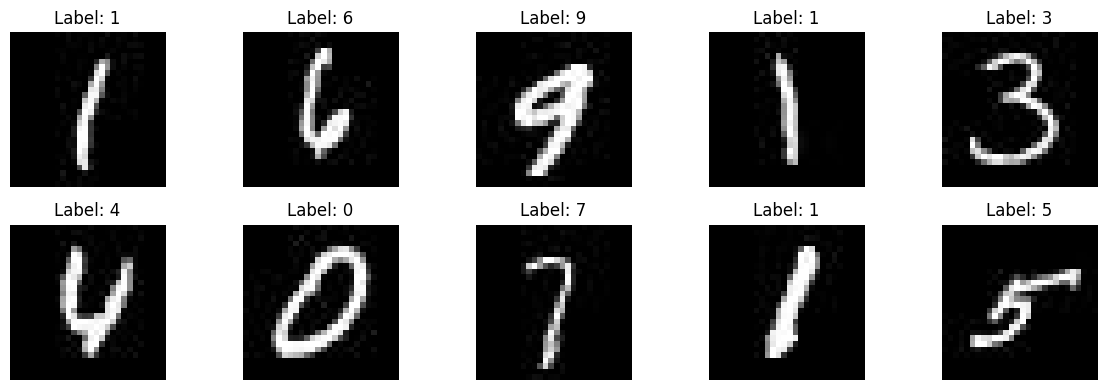

In [54]:
# Visualize raw input images (before training / after training đều được)
visualize_input_images_from_csv(
    csv_path=TRAINING_SAMPLE,
    num_images=10
)


In [55]:
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt


def load_mnist_csv(config: dict):
    """
    Input:
        config (dict):
            Required:
                - csv_path (str)
                - input_size (int)
                - output_size (int)
            Optional:
                - device (str)
                - seed (int)
                - val_split (float)
                - shuffle (bool)
                - normalize_mode (str): "none" | "standardize" | "center"
                - eps (float)
    Output:
        dict:
            - X_train, y_train_int, y_train_oh
            - X_val, y_val_int, y_val_oh
            - mean, std, normalize_mode
    """
    cfg = dict(config)
    device = torch.device(cfg.get("device", "cpu"))
    seed = int(cfg.get("seed", 42))
    val_split = float(cfg.get("val_split", 0.2))
    shuffle = bool(cfg.get("shuffle", True))
    normalize_mode = str(cfg.get("normalize_mode", "standardize")).lower()
    eps = float(cfg.get("eps", 1e-6))

    torch.manual_seed(seed)
    np.random.seed(seed)

    df = pd.read_csv(cfg["csv_path"])
    if "label" not in df.columns:
        raise ValueError("CSV must contain a 'label' column.")

    y_int = df["label"].astype(int).to_numpy()
    X = df.drop(columns=["label"]).to_numpy(dtype=np.float32)

    if X.shape[1] != int(cfg["input_size"]):
        raise ValueError(f"Expected input_size={cfg['input_size']} but CSV has {X.shape[1]} pixel columns.")

    # Ensure pixel scale is [0, 1]
    if float(np.max(X)) > 1.5:
        X = X / 255.0

    n = X.shape[0]
    idx = np.arange(n)
    if shuffle:
        np.random.shuffle(idx)

    n_val = int(round(n * val_split))
    val_idx = idx[:n_val]
    train_idx = idx[n_val:]

    X_train_np = X[train_idx]
    X_val_np = X[val_idx]
    y_train_np = y_int[train_idx]
    y_val_np = y_int[val_idx]

    # Normalize for ReLU/Softmax training stability
    if normalize_mode == "none":
        mean = np.zeros((1, X.shape[1]), dtype=np.float32)
        std = np.ones((1, X.shape[1]), dtype=np.float32)
    elif normalize_mode == "center":
        mean = np.mean(X_train_np, axis=0, keepdims=True).astype(np.float32)
        std = np.ones_like(mean, dtype=np.float32)
    elif normalize_mode == "standardize":
        mean = np.mean(X_train_np, axis=0, keepdims=True).astype(np.float32)
        std = np.std(X_train_np, axis=0, keepdims=True).astype(np.float32)
        std = np.maximum(std, eps).astype(np.float32)
    else:
        raise ValueError('normalize_mode must be "none", "center", or "standardize"')

    X_train_np = (X_train_np - mean) / std
    X_val_np = (X_val_np - mean) / std

    X_train = torch.tensor(X_train_np, dtype=torch.float32, device=device)
    y_train_int = torch.tensor(y_train_np, dtype=torch.long, device=device)
    X_val = torch.tensor(X_val_np, dtype=torch.float32, device=device)
    y_val_int = torch.tensor(y_val_np, dtype=torch.long, device=device)

    num_classes = int(cfg["output_size"])
    y_train_oh = torch.zeros((X_train.shape[0], num_classes), dtype=torch.float32, device=device)
    y_train_oh.scatter_(1, y_train_int.view(-1, 1), 1.0)
    y_val_oh = torch.zeros((X_val.shape[0], num_classes), dtype=torch.float32, device=device)
    y_val_oh.scatter_(1, y_val_int.view(-1, 1), 1.0)

    return {
        "X_train": X_train, "y_train_int": y_train_int, "y_train_oh": y_train_oh,
        "X_val": X_val, "y_val_int": y_val_int, "y_val_oh": y_val_oh,
        "mean": mean, "std": std, "normalize_mode": normalize_mode
    }


def train_ffnn_from_csv(config: dict):
    """
    Input:
        config (dict): Required:
            - csv_path, input_size, hidden_size, output_size
        Optional:
            - device, seed, epochs, batch_size, learning_rate, val_split, shuffle
            - normalize_mode: "standardize" recommended
            - save_path (str|None)
    Output:
        dict: model, history, train_acc, val_acc, y_val_int, val_out
    """
    cfg = dict(config)
    device = torch.device(cfg.get("device", "cpu"))
    seed = int(cfg.get("seed", 42))
    epochs = int(cfg.get("epochs", 50))
    batch_size = int(cfg.get("batch_size", 64))
    lr = float(cfg.get("learning_rate", 0.1))
    shuffle = bool(cfg.get("shuffle", True))
    save_path = cfg.get("save_path", None)

    torch.manual_seed(seed)
    np.random.seed(seed)

    data = load_mnist_csv(cfg)
    X_train = data["X_train"]
    y_train_int = data["y_train_int"]
    y_train_oh = data["y_train_oh"]
    X_val = data["X_val"]
    y_val_int = data["y_val_int"]
    y_val_oh = data["y_val_oh"]

    model = FFNeuralNetwork(config=cfg).to(device)

    # Detect training target type by trying a tiny forward and checking your class' backward expectation.
    with torch.no_grad():
        test_out = model.forward(X_train[:2])
    expects_onehot = (test_out.dim() == 2 and test_out.shape[1] == int(cfg["output_size"]) and
                      "backward" in dir(model) and model.backward.__code__.co_argcount >= 5)

    def _accuracy(out: torch.Tensor, y_true_int: torch.Tensor) -> float:
        pred = torch.argmax(out, dim=1)
        return float((pred == y_true_int).float().mean().item())

    def _ce_loss_from_softmax(probs: torch.Tensor, y_true_int: torch.Tensor) -> float:
        eps = 1e-12
        p = probs[torch.arange(probs.shape[0], device=probs.device), y_true_int]
        return float((-torch.mean(torch.log(p + eps))).item())

    history = {"train_loss": [], "val_loss": [], "train_acc": [], "val_acc": []}

    for _epoch in range(1, epochs + 1):
        if shuffle:
            perm = torch.randperm(X_train.shape[0], device=device)
            X_train = X_train[perm]
            y_train_int = y_train_int[perm]
            y_train_oh = y_train_oh[perm]

        for start in range(0, X_train.shape[0], batch_size):
            end = min(start + batch_size, X_train.shape[0])
            xb = X_train[start:end]

            if expects_onehot:
                yb = y_train_oh[start:end]
                out = model.train_step(xb, yb, lr)
            else:
                yb_int = y_train_int[start:end]
                out = model.train_step(xb, yb_int, lr)

        with torch.no_grad():
            train_out = model.forward(X_train)
            val_out = model.forward(X_val)

            train_acc = _accuracy(train_out, y_train_int)
            val_acc = _accuracy(val_out, y_val_int)

            # Logging loss:
            # - If output is softmax: use CE for logging
            # - Else fallback to MSE with one-hot
            if torch.all(train_out >= 0) and torch.allclose(torch.sum(train_out, dim=1), torch.ones(train_out.shape[0], device=train_out.device), atol=1e-2):
                train_loss = _ce_loss_from_softmax(train_out, y_train_int)
                val_loss = _ce_loss_from_softmax(val_out, y_val_int)
            else:
                train_loss = float(torch.mean((y_train_oh - train_out) ** 2).item())
                val_loss = float(torch.mean((y_val_oh - val_out) ** 2).item())

        history["train_loss"].append(train_loss)
        history["val_loss"].append(val_loss)
        history["train_acc"].append(train_acc)
        history["val_acc"].append(val_acc)

        # if _epoch % 10 == 0:
            # print(f"Epoch {_epoch}/{epochs} - loss: {train_loss:.4f} - acc: {train_acc:.4f} - val_loss: {val_loss:.4f} - val_acc: {val_acc:.4f}")

    if save_path:
        FFNeuralNetwork.save_weights(model, save_path)

    with torch.no_grad():
        val_out = model.forward(X_val).detach().cpu()

    return {
        "model": model,
        "history": history,
        "train_acc": history["train_acc"][-1],
        "val_acc": history["val_acc"][-1],
        "y_val_int": y_val_int.detach().cpu(),
        "val_out": val_out,
    }


def visualize_results(results: dict):
    """
    Input:
        results (dict): output of train_ffnn_from_csv
    Output:
        None
    """
    h = results["history"]
    epochs = np.arange(1, len(h["train_loss"]) + 1)

    plt.figure()
    plt.plot(epochs, h["train_loss"], label="train_loss")
    plt.plot(epochs, h["val_loss"], label="val_loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

    plt.figure()
    plt.plot(epochs, h["train_acc"], label="train_acc")
    plt.plot(epochs, h["val_acc"], label="val_acc")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.show()

    y_true = results["y_val_int"].numpy()
    y_pred = np.argmax(results["val_out"].numpy(), axis=1)
    C = int(results["val_out"].shape[1])

    cm = np.zeros((C, C), dtype=np.int64)
    for t, p in zip(y_true, y_pred):
        cm[int(t), int(p)] += 1

    plt.figure()
    plt.imshow(cm)
    plt.title("Confusion Matrix (val)")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.colorbar()
    plt.show()



Final train_acc: 0.981249988079071 | Final val_acc: 0.824999988079071


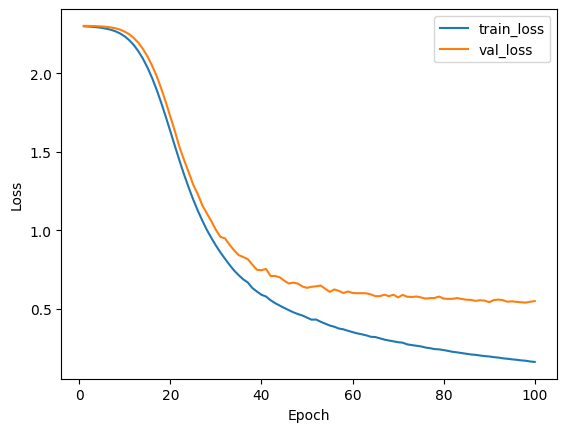

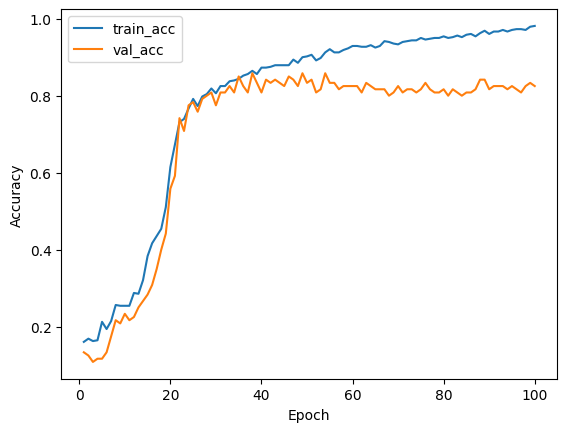

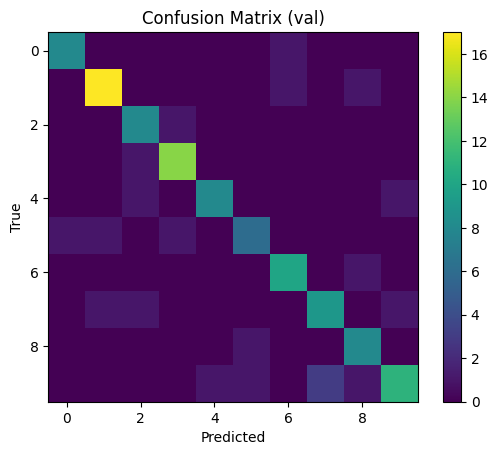

In [56]:

# Run
config = {
    "csv_path": TRAINING_SAMPLE,
    "input_size": 784,
    "hidden_size": 32,
    "output_size": 10,
    "device": "cpu",
    "seed": 42,
    "init_std": 0.01,
    "epochs": 100,
    "batch_size": 64,
    "learning_rate": 0.05,
    "val_split": 0.2,
    "shuffle": True,
    "normalize_mode": "none",
    "save_path": MODEL_TRAINING_SAMPLE,
}

results = train_ffnn_from_csv(config)
print("Final train_acc:", results["train_acc"], "| Final val_acc:", results["val_acc"])
visualize_results(results)

# print(results["history"]["train_loss"])


In [57]:
def evaluate_and_visualize_from_csv(config: dict, model_path: str = None, num_show: int = 10):
    """
    Input:
        config (dict): must include csv_path, input_size, output_size and training-time normalize_mode/seed/shuffle/val_split.
        model_path (str|None): path to saved weights; if None, use config["save_path"].
        num_show (int): number of random validation samples to visualize.
    Output:
        dict: {"val_acc": float, "picked_indices": np.ndarray, "y_true": np.ndarray, "y_pred": np.ndarray}
    """
    cfg = dict(config)
    device = torch.device(cfg.get("device", "cpu"))
    path = model_path if model_path is not None else cfg.get("save_path", None)
    if not path:
        raise ValueError("model_path is None and config['save_path'] is missing.")

    loaded_model = FFNeuralNetwork.load_weights(path, cfg).to(device)
    loaded_model.eval()

    data = load_mnist_csv(cfg)
    X_val = data["X_val"]
    y_val_int = data["y_val_int"]
    mean = data["mean"]
    std = data["std"]

    with torch.no_grad():
        val_out = loaded_model.forward(X_val)
        val_pred = torch.argmax(val_out, dim=1)
        val_acc = float((val_pred == y_val_int).float().mean().item())

    print("Validation accuracy (loaded):", val_acc)

    df_full = pd.read_csv(cfg["csv_path"])
    n_total = len(df_full)
    val_split = float(cfg.get("val_split", 0.2))
    n_val = int(round(n_total * val_split))

    seed = int(cfg.get("seed", 42))
    shuffle = bool(cfg.get("shuffle", True))
    np.random.seed(seed)
    idx = np.arange(n_total)
    if shuffle:
        np.random.shuffle(idx)
    val_idx = idx[:n_val]

    picked = np.random.choice(val_idx, size=min(num_show, len(val_idx)), replace=False)

    y_true_list = []
    y_pred_list = []

    plt.figure(figsize=(12, 4))
    for i, ridx in enumerate(picked):
        true_label = int(df_full.loc[ridx, "label"])
        x = df_full.drop(columns=["label"]).iloc[ridx].to_numpy(dtype=np.float32)

        if float(np.max(x)) > 1.5:
            x01 = x / 255.0
        else:
            x01 = x

        x_norm = (x01.reshape(1, -1) - mean) / std
        X = torch.tensor(x_norm, dtype=torch.float32, device=device)

        with torch.no_grad():
            probs = loaded_model.forward(X).detach().cpu().numpy().reshape(-1)

        pred_label = int(np.argmax(probs))
        conf = float(probs[pred_label])

        y_true_list.append(true_label)
        y_pred_list.append(pred_label)

        plt.subplot(2, 5, i + 1)
        plt.imshow(x01.reshape(28, 28))
        plt.axis("off")
        plt.title(f"T:{true_label} P:{pred_label}\n{conf:.2f}")

    plt.tight_layout()
    plt.show()

    return {
        "val_acc": val_acc,
        "picked_indices": picked,
        "y_true": np.array(y_true_list, dtype=int),
        "y_pred": np.array(y_pred_list, dtype=int),
    }


Saved weights to: ffnn_mnist_state_dict.pt
Loaded weights from: ffnn_mnist_state_dict.pt


Validation accuracy (loaded): 0.824999988079071


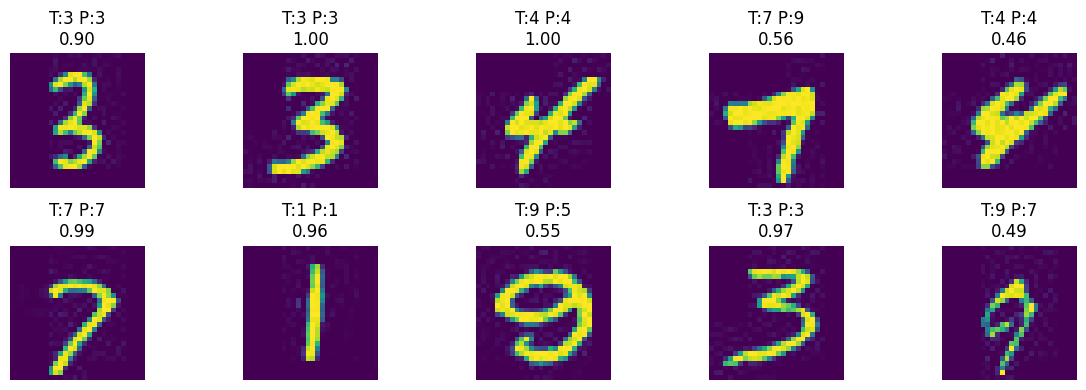

In [58]:

# 1) Save weights
FFNeuralNetwork.save_weights(results["model"], config["save_path"])
print("Saved weights to:", config["save_path"])

# 2) Load weights back
loaded_model = FFNeuralNetwork.load_weights(config["save_path"], config).to(torch.device(config.get("device", "cpu")))
loaded_model.eval()
print("Loaded weights from:", config["save_path"])

# 3) Reload data to get X_val, y_val_int and normalization stats (mean/std)
data = load_mnist_csv(config)
X_val = data["X_val"]
y_val_int = data["y_val_int"]
mean = data["mean"]
std = data["std"]

# 4) Evaluate on validation split
with torch.no_grad():
    val_out = loaded_model.forward(X_val)
    val_pred = torch.argmax(val_out, dim=1)
    val_acc = float((val_pred == y_val_int).float().mean().item())

print("Validation accuracy (loaded):", val_acc)

# 5) Visualize + predict a few random validation samples
df_full = pd.read_csv(config["csv_path"])  # for true pixels to display
n_total = len(df_full)
val_split = float(config.get("val_split", 0.2))
n_val = int(round(n_total * val_split))

# reproduce the same shuffle split indices using the same seed
seed = int(config.get("seed", 42))
shuffle = bool(config.get("shuffle", True))
np.random.seed(seed)
idx = np.arange(n_total)
if shuffle:
    np.random.shuffle(idx)
val_idx = idx[:n_val]

# pick random samples from validation indices
num_show = 10
picked = np.random.choice(val_idx, size=min(num_show, len(val_idx)), replace=False)

plt.figure(figsize=(12, 4))
for i, ridx in enumerate(picked):
    true_label = int(df_full.loc[ridx, "label"])
    x = df_full.drop(columns=["label"]).iloc[ridx].to_numpy(dtype=np.float32)

    # Ensure display image is in [0,1]
    if float(np.max(x)) > 1.5:
        x01 = x / 255.0
    else:
        x01 = x

    # Normalize exactly like training
    x_norm = (x01.reshape(1, -1) - mean) / std
    X = torch.tensor(x_norm, dtype=torch.float32, device=torch.device(config.get("device", "cpu")))

    with torch.no_grad():
        probs = loaded_model.forward(X).detach().cpu().numpy().reshape(-1)
    pred_label = int(np.argmax(probs))
    conf = float(probs[pred_label])

    plt.subplot(2, 5, i + 1)
    plt.imshow(x01.reshape(28, 28))
    plt.axis("off")
    plt.title(f"T:{true_label} P:{pred_label}\n{conf:.2f}")

plt.tight_layout()
plt.show()


In [59]:
# Run (relative paths):
saved_path, stats = build_mnist_like_csv(
    dataset_root=DATASET_DIR,
    split="trainingSet",
    out_csv=TRAINING_SET,
    normalize="div255"
)
print(saved_path, stats)

mnist_trainingSet.csv {'rows': 42000, 'cols': 785, 'chosen_dir': 'mnistasjpg_data\\trainingSet\\trainingSet', 'skipped': 0}


Final train_acc: 1.0 | Final val_acc: 0.9610714316368103


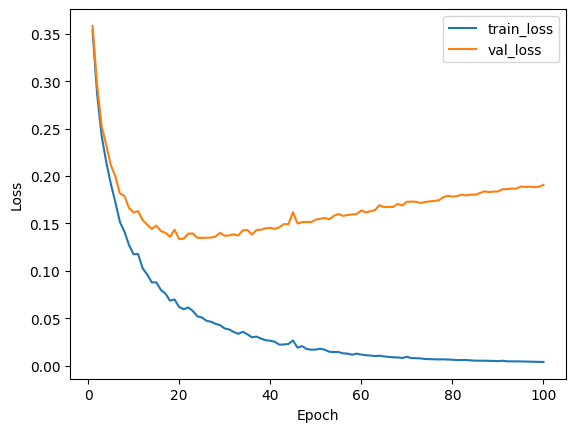

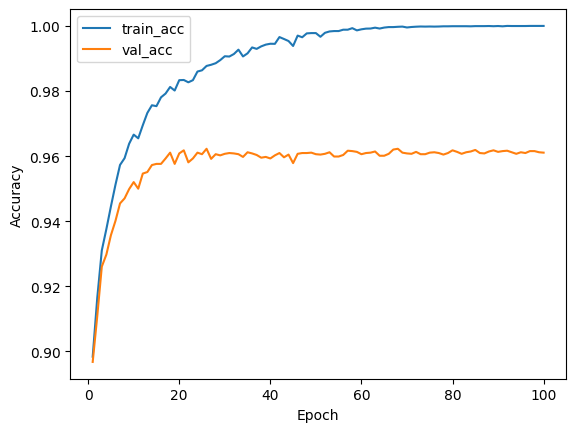

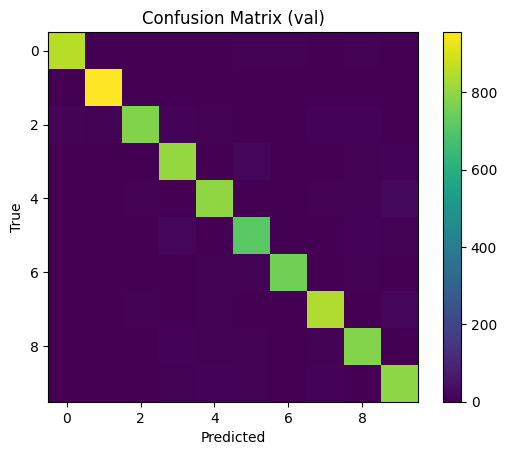

In [60]:
# Run
config2 = {
    "csv_path": TRAINING_SET,
    "input_size": 784,
    "hidden_size": 32,
    "output_size": 10,
    "device": "cpu",
    "seed": 42,
    "init_std": 0.01,
    "epochs": 100,
    "batch_size": 32,
    "learning_rate": 0.05,
    "val_split": 0.2,
    "shuffle": True,
    "normalize_mode": "none",
    "save_path": MODEL_TRAINING_SET,
}

resultsSet = train_ffnn_from_csv(config2)
print("Final train_acc:", resultsSet["train_acc"], "| Final val_acc:", resultsSet["val_acc"])
visualize_results(resultsSet)

# print(results["history"]["train_loss"])

Validation accuracy (loaded): 0.9610714316368103


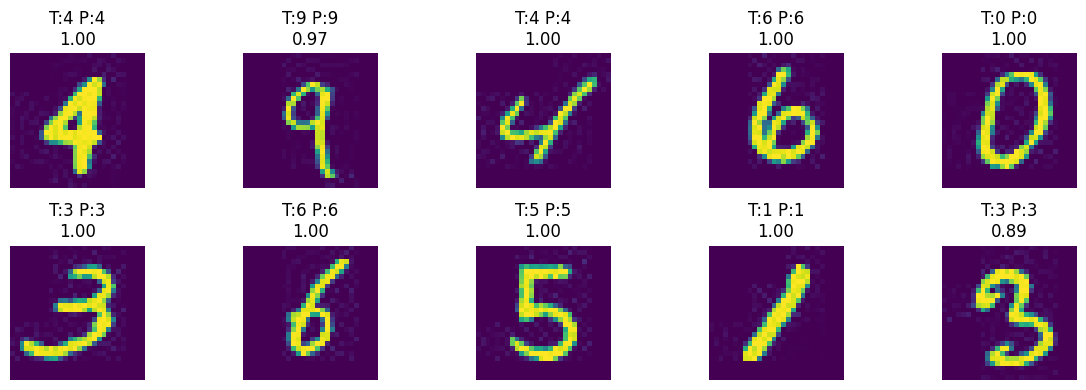

In [61]:
# Example for trainingSet
report_set = evaluate_and_visualize_from_csv(config2, model_path=MODEL_TRAINING_SET, num_show=10)


In [74]:
def visualize_model_architecture(config, title="Deep Learning Architecture Flow"):
    """
    Visualize network architecture with boxes and arrows.
    
    Args:
        config (dict): Configuration dict with input_size, hidden_size, output_size.
        title (str): Title for the visualization.
        
    Returns:
        None
    """
    import matplotlib.pyplot as plt
    
    # Build display blocks
    display_blocks = []
    
    # INPUT LAYER
    input_size = config.get('input_size', 784)
    display_blocks.append({"type": "input", "label": f"INPUT LAYER\n({input_size})"})
    
    # HIDDEN LAYER
    hidden_size = config.get('hidden_size', 128)
    display_blocks.append({"type": "fc", "label": f"HIDDEN LAYER\n({hidden_size})\n[RELU]", "is_output": False})
    
    # OUTPUT LAYER
    output_size = config.get('output_size', 10)
    display_blocks.append({"type": "fc", "label": f"OUTPUT LAYER\n({output_size})\n[SOFTMAX]", "is_output": True})
    
    # --- Draw graph ---
    plt.figure(figsize=(max(10, len(display_blocks) * 2.8), 4))
    ax = plt.gca()
    ax.axis("off")
    
    x_start = 0.05
    y = 0.5
    box_w = 0.18
    box_h = 0.6
    gap = 0.25
    
    for i, block in enumerate(display_blocks):
        x = x_start + i * gap
        
        # Choose different colors for each layer type
        if block["type"] == "input":
            color = '#ff9999'  # Light red
        elif block.get("is_output"):
            color = '#99ff99'  # Light green
        else:
            color = '#99ccff'  # Light blue
        
        # Draw Box
        rect = plt.Rectangle((x, y - box_h/2), box_w, box_h, fill=True, color=color, alpha=0.4, ec='black', lw=2)
        ax.add_patch(rect)
        
        # Add Text
        ax.text(x + box_w/2, y, block["label"], ha="center", va="center", fontsize=10, fontweight='bold')
        
        # Draw arrow connection
        if i < len(display_blocks) - 1:
            ax.annotate(
                "",
                xy=(x + gap, y),
                xytext=(x + box_w, y),
                arrowprops={"arrowstyle": "->", "lw": 2, "color": "gray"},
            )
    
    plt.title(title, pad=30, fontsize=15, fontweight='bold')
    plt.tight_layout()
    plt.show()


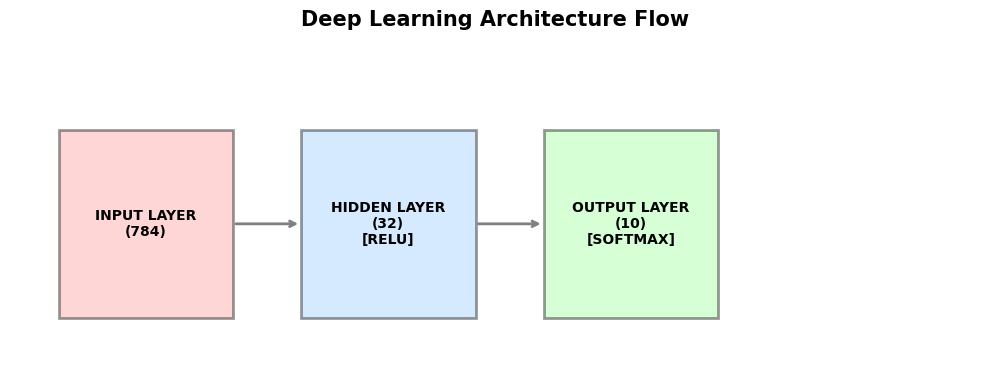

In [75]:
visualize_model_architecture(config)

In [64]:
visualize_model_architecture(config2)

Feed-Forward Neural Network Architecture
----------------------------------------
Input layer : 784 neurons
Hidden layer: 32 neurons (ReLU)
Output layer: 10 neurons (Softmax)


In [ ]:
# Predict Test
def predict_and_visualize_testset(
    model_path: str,
    dataset_root: str,
    split: str,
    config: dict,
    num_images: int = 10,
    seed: int = 42
):
    """
    Load model, predict on testSet (no labels), and visualize n images.
    
    Args:
        model_path (str): Path to saved model weights.
        dataset_root (str): Root directory of dataset (e.g., "mnistasjpg_data").
        split (str): Split folder name (e.g., "testSet").
        config (dict): Model config used during training (must match training config).
        num_images (int): Number of images to visualize.
        seed (int): Random seed for reproducibility.
        
    Returns:
        dict: {"predictions": np.ndarray, "picked_indices": np.ndarray, "image_paths": list}
    """
    import os
    from pathlib import Path
    import numpy as np
    import pandas as pd
    import torch
    import matplotlib.pyplot as plt
    from PIL import Image
    
    np.random.seed(seed)
    torch.manual_seed(seed)
    
    # Load model
    device = torch.device(config.get("device", "cpu"))
    model = FFNeuralNetwork.load_weights(model_path, config).to(device)
    model.eval()
    print(f"Loaded model from: {model_path}")
    
    # Get normalization stats from training config
    # We need to load training data to get mean/std used during training
    train_config = dict(config)
    if "csv_path" not in train_config:
        raise ValueError("config must include 'csv_path' of training data to get normalization stats")
    
    # Load training data to get normalization stats
    train_data = load_mnist_csv(train_config)
    mean = train_data["mean"]
    std = train_data["std"]
    normalize_mode = train_data["normalize_mode"]
    
    # Collect test images (no labels)
    root = Path(dataset_root)
    split_dir = root / split / split if (root / split / split).is_dir() else root / split
    
    if not split_dir.is_dir():
        raise FileNotFoundError(f"TestSet folder not found: {split_dir}")
    
    exts = {".jpg", ".jpeg", ".png", ".bmp", ".pgm", ".tif", ".tiff"}
    image_paths = []
    
    # Collect all image files (testSet has no label folders, images are directly in split_dir)
    for img_path in sorted(split_dir.rglob("*")):
        if img_path.is_file() and img_path.suffix.lower() in exts:
            image_paths.append(str(img_path))
    
    if not image_paths:
        raise RuntimeError(f"No images found in: {split_dir}")
    
    print(f"Found {len(image_paths)} images in testSet")
    
    # Pick random images to visualize
    picked_indices = np.random.choice(len(image_paths), size=min(num_images, len(image_paths)), replace=False)
    picked_paths = [image_paths[i] for i in picked_indices]
    
    # Predict and visualize
    predictions = []
    
    plt.figure(figsize=(15, 6))
    for i, img_path in enumerate(picked_paths):
        # Load and preprocess image
        img = Image.open(img_path).convert("L")
        if img.size != (28, 28):
            img = img.resize((28, 28), resample=Image.BILINEAR)
        
        x = np.asarray(img, dtype=np.float32).reshape(-1)
        
        # Normalize to [0, 1]
        if np.max(x) > 1.5:
            x = x / 255.0
        
        # Apply same normalization as training
        x_norm = (x.reshape(1, -1) - mean) / std
        X = torch.tensor(x_norm, dtype=torch.float32, device=device)
        
        # Predict
        with torch.no_grad():
            probs = model.forward(X).detach().cpu().numpy().reshape(-1)
        
        pred_label = int(np.argmax(probs))
        conf = float(probs[pred_label])
        predictions.append(pred_label)
        
        # Visualize
        plt.subplot(2, 5, i + 1)
        plt.imshow(x.reshape(28, 28), cmap="gray")
        plt.title(f"Prediction: {pred_label}\nConfident: {conf:.3f}", fontsize=10)
        plt.axis("off")
    
    plt.tight_layout()
    plt.show()
    
    return {
        "predictions": np.array(predictions, dtype=int),
        "picked_indices": picked_indices,
        "image_paths": picked_paths
    }

Loaded model from: ffnn_mnist_state_dict_set.pt
Found 28000 images in testSet


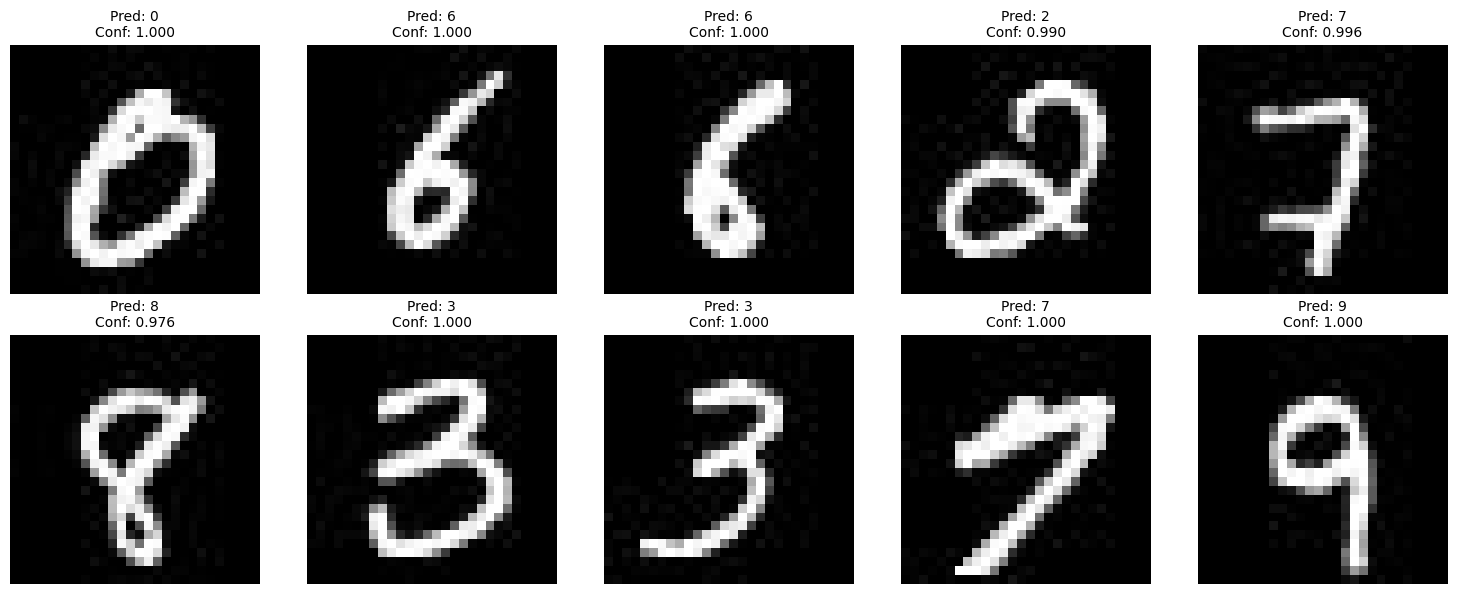


Predicted labels: [0 6 6 2 7 8 3 3 7 9]


In [73]:
# Load MODEL_TRAINING_SET and predict on testSet
test_config = {
    "csv_path": TRAINING_SET,  # Use training set to get normalization stats
    "input_size": 784,
    "hidden_size": 32,
    "output_size": 10,
    "device": "cpu",
    "seed": 42,
    "init_std": 0.01,
    "val_split": 0.2,
    "shuffle": True,
    "normalize_mode": "none",  # Must match training config
}

results = predict_and_visualize_testset(
    model_path=MODEL_TRAINING_SET,
    dataset_root=DATASET_DIR,
    split="testSet",
    config=test_config,
    num_images=10,
    seed=42
)

print(f"\nPredicted labels: {results['predictions']}")


### EXPERIMENT

### CONFIG hidden_size and learning_rate

In [ ]:
CONFIG_32 = {
    'mode': 'set',
    'input_size': 784,
    'hidden_size': 32,
    'output_size': 10,
    'epochs': 100,
    'learning_rate': 0.05
}

CONFIG_64 = {
    'mode': 'set',
    'input_size': 784,
    'hidden_size': 64,
    'output_size': 10,
    'epochs': 100,
    'learning_rate': 0.1
}


In [66]:
def create_training_config(base_config, csv_path=TRAINING_SET):
    """Create training config from base config.
    
    Args:
        base_config (dict): Base configuration dict
        csv_path (str): Path to CSV file
        
    Returns:
        dict: Training configuration
    """
    return {
        "csv_path": csv_path,
        "input_size": base_config['input_size'],
        "hidden_size": base_config['hidden_size'],
        "output_size": base_config['output_size'],
        "device": "cpu",
        "seed": 42,
        "init_std": 0.01,
        "epochs": base_config['epochs'],
        "batch_size": 64,
        "learning_rate": base_config['learning_rate'],
        "val_split": 0.2,
        "shuffle": True,
        "normalize_mode": "none",
        "save_path": None,  # Không cần save
    }


In [67]:
# Train with CONFIG (hidden_size=128)
print("=" * 60)
print("Training with CONFIG: hidden_size=128, learning_rate=0.2")
print("=" * 60)

train_config_128 = create_training_config(CONFIG)
results_128 = train_ffnn_from_csv(train_config_128)

print(f"Train Accuracy: {results_128['train_acc']:.6f}")
print(f"Validation Accuracy: {results_128['val_acc']:.6f}")
print()


Training with CONFIG: hidden_size=128, learning_rate=0.2


Train Accuracy: 1.000000
Validation Accuracy: 0.974881



In [68]:
# Train with CONFIG_32 (hidden_size=32)
print("=" * 60)
print("Training with CONFIG_32: hidden_size=32, learning_rate=0.05")
print("=" * 60)

train_config_32 = create_training_config(CONFIG_32)
results_32 = train_ffnn_from_csv(train_config_32)

print(f"Train Accuracy: {results_32['train_acc']:.6f}")
print(f"Validation Accuracy: {results_32['val_acc']:.6f}")
print()


Training with CONFIG_32: hidden_size=32, learning_rate=0.05
Train Accuracy: 0.998155
Validation Accuracy: 0.961667



In [69]:
# Train with CONFIG_64 (hidden_size=64)
print("=" * 60)
print("Training with CONFIG_64: hidden_size=64, learning_rate=0.1")
print("=" * 60)

train_config_64 = create_training_config(CONFIG_64)
results_64 = train_ffnn_from_csv(train_config_64)

print(f"Train Accuracy: {results_64['train_acc']:.6f}")
print(f"Validation Accuracy: {results_64['val_acc']:.6f}")
print()


Training with CONFIG_64: hidden_size=64, learning_rate=0.1
Train Accuracy: 1.000000
Validation Accuracy: 0.969048



In [70]:
# Summary comparing accuracy
print("=" * 60)
print("SUMMARY - ACCURACY COMPARISON")
print("=" * 60)
print()
print(f"{'Config':<20} {'Hidden Size':<15} {'Learning Rate':<15} {'Train Acc':<15} {'Val Acc':<15}")
print("-" * 80)
print(f"{'CONFIG':<20} {CONFIG['hidden_size']:<15} {CONFIG['learning_rate']:<15} {results_128['train_acc']:<15.6f} {results_128['val_acc']:<15.6f}")
print(f"{'CONFIG_32':<20} {CONFIG_32['hidden_size']:<15} {CONFIG_32['learning_rate']:<15} {results_32['train_acc']:<15.6f} {results_32['val_acc']:<15.6f}")
print(f"{'CONFIG_64':<20} {CONFIG_64['hidden_size']:<15} {CONFIG_64['learning_rate']:<15} {results_64['train_acc']:<15.6f} {results_64['val_acc']:<15.6f}")
print()
print("=" * 60)
print("Conclusion:")
print(f"- Best config (Validation Accuracy): ", end="")
best_val = max(results_128['val_acc'], results_32['val_acc'], results_64['val_acc'])
if best_val == results_128['val_acc']:
    print(f"CONFIG (hidden_size=128) with val_acc={best_val:.6f}")
elif best_val == results_32['val_acc']:
    print(f"CONFIG_32 (hidden_size=32) with val_acc={best_val:.6f}")
else:
    print(f"CONFIG_64 (hidden_size=64) with val_acc={best_val:.6f}")
print("=" * 60)


SUMMARY - ACCURACY COMPARISON

Config               Hidden Size     Learning Rate   Train Acc       Val Acc        
--------------------------------------------------------------------------------
CONFIG               128             0.2             1.000000        0.974881       
CONFIG_32            32              0.05            0.998155        0.961667       
CONFIG_64            64              0.1             1.000000        0.969048       

Conclusion:
- Best config (Validation Accuracy): CONFIG (hidden_size=128) with val_acc=0.974881
